В качестве коллекции для моделирования я выбрала газетный корпус (19381 газетная статья "РБК" за 2011-2014 годы -- часть газетного корпуса НКРЯ). Все тексты предварительно отчистила от html-разметки, токенизировала, привела к нижнему регистру и удалила всё, что не является словом русского языка (делала в PyCharm'е, воспроизводить тут заняло бы много времени).

In [1]:
import os 
import codecs
import numpy
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
texts = []
wordsCount = []
pathIn = '/home/anya/RBCDaily'
for root, dirs, files in os.walk(pathIn):
    for file in files:
        fileIn = os.path.join(root, file)
        with codecs.open(fileIn) as f:
            words = []
            for line in f:
                for w in line.strip('\n').split():
                    try:
                        w = morph.parse(w)[0].normal_form.replace('ё', 'е')
                    except:
                        print('Cannt normalize the word %s' % w)
                    words.append(w)
            texts.append(words)
            wordsCount.append(len(words))
print('Количество документов:', +len(texts))
print('Средняя длина документа в словах:', +int(numpy.mean(wordsCount)))
print('Количество слов:', +sum(wordsCount))

Количество документов: 19381
Средняя длина документа в словах: 468
Количество слов: 9070459


Далее использую код с семинара для построения словаря и корпуса частот встречаемости слов в документах.

In [2]:
import logging
from gensim import corpora, similarities
from gensim.models import ldamodel

dictionary = corpora.Dictionary(texts)
print('Original: {}'.format(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.5, keep_n=None)
print('Filtered: {}'.format(dictionary))
print()
corpus = [dictionary.doc2bow(text) for text in texts]
print('The first 20 words of the first document:\n', corpus[0][0:20])

Original: Dictionary(101647 unique tokens: ['неосновательный', 'максималистский', 'умолчание', 'кровосмесительный', 'ресурсообеспечить']...)
Filtered: Dictionary(34243 unique tokens: ['неосновательный', 'предъявление', 'правомочный', 'дизайнер', 'билль']...)

The first 20 words of the first document:
 [(60, 1), (411, 4), (490, 1), (607, 2), (1077, 1), (1086, 1), (1439, 1), (1619, 2), (1754, 1), (1949, 1), (2000, 1), (2361, 1), (2768, 1), (2784, 1), (2818, 1), (2903, 1), (3406, 1), (3446, 1), (3468, 1), (3482, 3)]


Строю модель с 50 темами.

In [7]:
from time import time 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=50, chunksize=500, update_every=1, passes=4)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.02
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online LDA training, 50 topics, 4 passes over the supplied corpus of 19381 documents, updating model once every 500 documents, evaluating perplexity every 5000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #500/19381
INFO:gensim.models.ldamodel:merging changes from 500 documents into a model of 19381 documents
INFO:gensim.models.ldamodel:topic #39 (0.020): 0.005*человек + 0.004*рынок + 0.004*рубль + 0.004*или + 0.004*миллион + 0.004*доллар + 0.004*мы + 0.003*россия + 0.003*самый + 0.003*есть
INFO:gensim.models.ldamodel:topic #43 (0.020): 0.006*рынок + 0.005*миллиард + 0.004*страна + 0.003*банка + 0.003*мы + 0.003*рубль + 0.003*считать + 0.003*россия + 0.003*миллион + 0.003*или
INFO:gensim.models.ldamodel:topic #5 (0.020): 0.006*доллар + 0.004*мы + 0.00

CPU times: user 16min 8s, sys: 34.2 s, total: 16min 42s
Wall time: 10min 45s


Перплексия -- 281,4, время обучения -- 10мин 45с.

Топ-15 слов для каждой темы:

In [8]:
top_words = [[word for _, word in lda.show_topic(topicNumber, topn=15)] 
             for topicNumber in range(lda.num_topics)]
for i in range(len(top_words)):
    print(i+1, ' '.join(top_words[i]), '\n')

1 матч команда чемпионат клуб сезон победа сборный игра турнир лига соперник после счет чемпион играть 

2 проект москва метр строительство город кв тысяча объект площадь участок недвижимость территория центр миллион комплекс 

3 миллион доллар миллиард составить рост показатель прошлое квартал итог вырасти продажа чем рынок первое выручка 

4 пользователь сайт сервис устройство система технология информация интернет электронный приложение мобильный дать смартфон сеть или 

5 ржд транспортный транспорт дорога перевозка железнодорожный вагон груз оператор километр железный парк грузовой поезд метро 

6 доллар сша американский китай китайский однако финансовый миллиард страна власть британский крупный мир чтобы япония 

7 оператор связь ростелеком сеть услуга мтс фон мег абонент потребитель рынок электроэнергия представитель вымпел мощность 

8 рубль миллиард бюджет расход средство программа доход бюджетный сумма тариф повышение деньга зарплата минфин счет 

9 налог налоговый ставка бизн

Во-первый, можно заметить ошибки лемматизации (см., например, топик 17 -- очевидно, PyMorphy считает Род.п. существительного банк начальной формой существительного банка; PyMorphy не умеет снимать контекстную омонимию, надо было использовать Mystem).

Во-вторых, как кажется, что кроме автоматической фильтрации редких и наиболее частотных слов, стоило бы предварительно удалить предлоги, союзы, частицы, местоимения и модльные глаголы типа можно, надо (многие из них, конечно, попадают в класс либо редких, либо наиболее частотных слов, но не все -- см., например, топики 35, 40). Возможно, при этом надо будет повысить порог верхней границы частотности с 0,5 до 0,6-0,7. Кроме того, было бы хорошо понимать, что московский и Москва -- это об одном и том же, но качественного инсртрумента стемминга русского языка мне не известно.

В-третьих, на мой взгляд, некоторые топики было бы логично объединить, поэтому решила также построить модель с 25 темами.

In [3]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=25, chunksize=500, update_every=1, passes=4)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.04
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online LDA training, 25 topics, 4 passes over the supplied corpus of 19381 documents, updating model once every 500 documents, evaluating perplexity every 5000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #500/19381
INFO:gensim.models.ldamodel:merging changes from 500 documents into a model of 19381 documents
INFO:gensim.models.ldamodel:topic #22 (0.040): 0.005*рубль + 0.005*миллион + 0.004*проект + 0.004*россия + 0.004*миллиард + 0.004*рынок + 0.003*если + 0.003*российский + 0.003*мы + 0.003*тысяча
INFO:gensim.models.ldamodel:topic #9 (0.040): 0.003*россия + 0.003*рынок + 0.003*если + 0.003*господин + 0.003*слово + 0.003*директор + 0.003*самый + 0.003*тысяча + 0.003*человек + 0.003*другой
INFO:gensim.models.ldamodel:topic #23 (0.040): 0.005*миллиард 

CPU times: user 22min 25s, sys: 1min 4s, total: 23min 30s
Wall time: 39min 17s


Перплексия -- 283,1, время обучения -- 39мин 17с. Так долго обучалась, потому что на компьютере было запущено два процесса одновременно; до этого, когда пробовала, обучение занимало около 7мин, перплексия тоже была меньше 276 -- не знаю, почему такая разница в перплексии.

In [11]:
top_words = [[word for _, word in lda.show_topic(topicNumber, topn=15)] 
             for topicNumber in range(lda.num_topics)]
for i in range(len(top_words)):
    print(i+1, ' '.join(top_words[i]), '\n')

1 директор господин сотрудник работа совет новый пенсионный пост должность работать руководитель страхование страховщик управление руководство 

2 доллар акция миллион миллиард сделка актив акционер доля бумага рубль продажа инвестор продать биржа получить 

3 партия выбор депутат россия власть путин политический человек президент господин кандидат владимир единый мы сергей 

4 фас рынок цена оператор ростелеком рубль участник тариф конкурс торг служба антимонопольный решение представитель фсфр 

5 москва тысяча метр город кв проект площадь строительство объект миллион недвижимость участок центр рубль территория 

6 проект рубль фонд развитие миллиард средство программа регион мы инвестиция создание работа россия деньга новый 

7 том нефть миллион цена тысяча производство добыча месторождение доллар российский рынок запас экспорт страна поставка 

8 сайт пользователь сервис тысяча устройство миллион интернет информация или электронный сеть приложение продукт можно мы 

9 фильм работа т

Проанализировать получившиеся топики проще всего с помощью динамической визуализации:

In [4]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

/home/anya/anaconda3/lib/python3.5/site-packages/pandas/__init__.py:7: DeprecationWarning: bad escape \s
  from pandas import hashtable, tslib, lib
/home/anya/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/anya/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/anya/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/anya/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/anya/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56:

Картинка с примером, чтобы не загружать код:

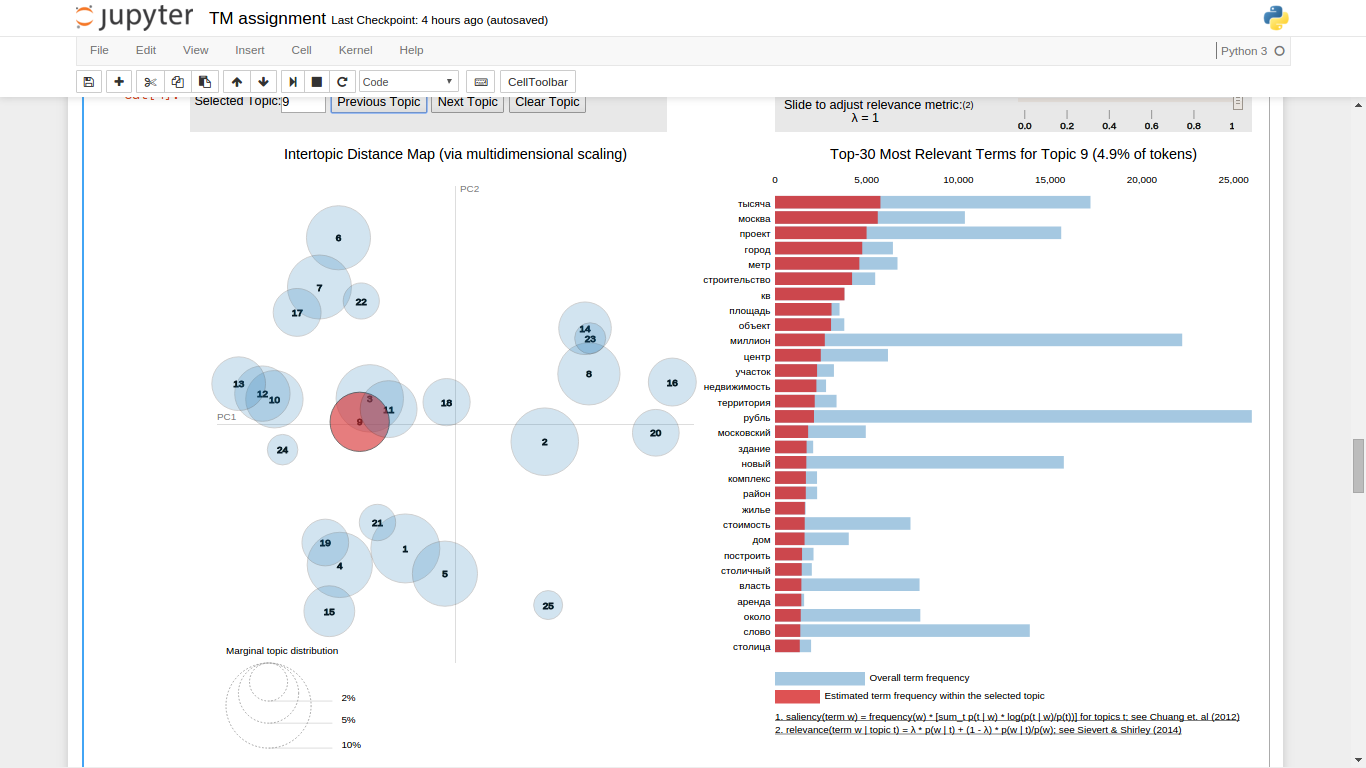

In [5]:
from IPython.display import Image
Image(filename='/home/anya/topic modeling/vis.png')

Теперь посмотрим, какие топики модель предскажет для нового новостного документа и уже известного.
В первом случае взяла случайную новость 2015г. с сайта РБК (http://www.rbc.ru/finances/21/07/2015/55adbd999a7947f0e0c42e24), токенизировала самым простым способом, лемматизировала, представила в формате bow. Во втором случае использовала первый документ коллекции. На втором примере особенно видно, что наиболее вероятные из предсказанных топиков расположены недалеко друг от друга на карте, отражающей расстояния между топиками (это 5 и 19 топики).

In [23]:
import nltk, string
with open('/home/anya/topic modeling/doc.txt', encoding='utf-8') as f:
    doc = f.read()
    doc = nltk.word_tokenize(doc)
    doc = [w.replace('«', '').replace('»', '').lower() for w in doc if w not in string.punctuation and not w == '—']
    doc = [morph.parse(w)[0].normal_form.replace('ё', 'е') for w in doc]
    print(' '.join(doc))

банк развитие брикс открыться в шанхай банк развитие брикс официально открыться утром в вторник в шанхай соглашение о он создание быть подписать по итог саммит брикс в бразилия 16 июль 2014 год банк позиционироваться как альтернатива мвф новый банк развитие нбр new development bank открыться спустя год после саммит брикс в бразилия по итог который быть объявить о создание это институт наш цель не оспорить существующий система но по-своему она совершенствовать и дополнять заявить на церемония открытие президент нбр кундапур ваман каматха цитата по reuters страна брикс рассматривать новый банк развитие в качество альтернатива международный финансовый институт такой как мвф и всемирный банк банк быть заниматься финансирование инфраструктурный и девелоперский проект в страна организация соглашение о создание нбр представитель страна брикс подписать в июль 2014 год по итог саммит в бразильский город форталеза российский доля в он уставный капиталь составлять 2 миллиард первоначальный уставн

In [43]:
lda[dictionary.doc2bow(doc)]

[(0, 0.036096282219767017),
 (3, 0.018903317314981603),
 (7, 0.041330904950680716),
 (13, 0.13792211647759753),
 (15, 0.053825503987080102),
 (18, 0.12942616172386967),
 (20, 0.024322287895633714),
 (21, 0.18279833044581487),
 (23, 0.013803994305304613),
 (24, 0.33828695850198226)]

In [47]:
' '.join(texts[0])

'вслед за борис березовский и роман абрам в лондонский суд вскоре мочь начать выяснять отношение алексей алякина и сергей полонский так и не суметь стать владелец девелоперский компания бывший господин алякина весь еще надеяться получить многомиллионный неустойка за разрыв договор а также деньга который он успеть заплатить полонский наиболее вероятный способ он считать подача иск в лондонский суд обычно разбирательство по английский право длиться долго и требовать немалый расход напоминать эксперт вчера стать известно что константин баглай и александр карачинский арестованный в конец прошлое год вместе с бизнесмен сергей полонский быть освободить из камбоджийский тюрьма по слово председатель правление компания и адвокат полонский александр добровинский это стать возможно после тот как март адвокат подать соответствующий прошение решение о освобождение самый основатель компания мочь быть принять к конец следующий неделя сказать господин добровинский рбк впрочем после вероятный освобожде

In [50]:
lda[corpus[0]]

[(2, 0.019444300363438305),
 (3, 0.011119182370674404),
 (5, 0.35804694404716964),
 (8, 0.084564651032589533),
 (9, 0.010289606031621334),
 (13, 0.10041938106096583),
 (17, 0.06682731536992309),
 (19, 0.31247513559516416),
 (20, 0.034370736036511931)]

Мне стало интересно, как, если не подбором, можно определить количество топиков. Насколько я поняла, мы предполагаем, что каждому тексту соответствует набор топиков с определенной вероятностью. Но в одном из блогов (http://sujitpal.blogspot.ru/) был  предложен  метод определения количество кластеров (~ топиков), на которые можно разбить все документы коллекции, так что каждый документ соответствует определенному топику (а не топикам). Я решила посмотреть, какая модель получается при таком подходе.

(Чтобы не зупускать код, привожу ниже графики, полученные в результате работы алгориитма, позаимствованного из блога)

In [9]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
tfidf = gensim.models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
fcoords = open("coords.csv", 'w')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()
MAX_K = 10
X = np.loadtxt("coords.csv", delimiter="\t")
ks = range(1, MAX_K + 1)
inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_ 
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]
elbow = np.argmin(diff3[3:]) + 3
plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()
NUM_TOPICS = 4
X = np.loadtxt("coords.csv", delimiter="\t")
kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_
colors = ["b", "c", "r", "m"]
for i in range(X.shape[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)    
plt.show()

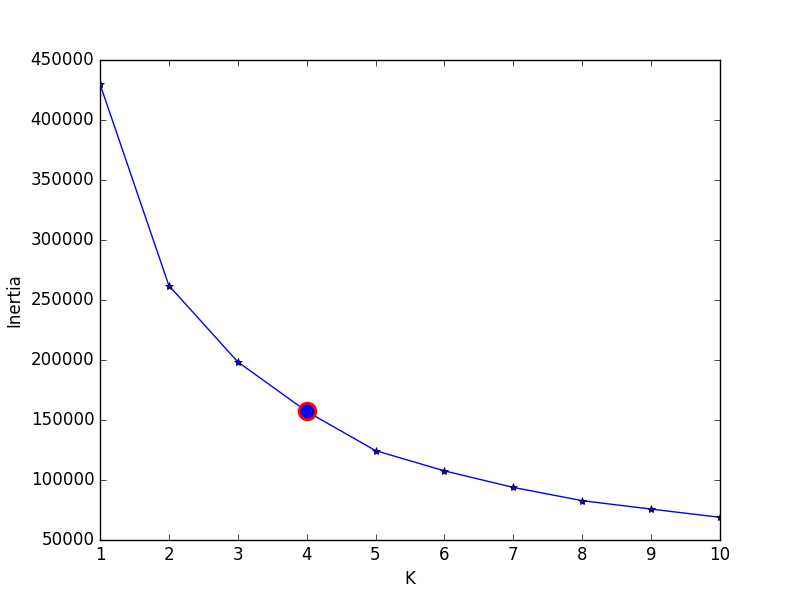

In [10]:
Image(filename='/home/anya/topic modeling/clusterNumber.png')

Если верить этому алгоритму, в нашей коллекции всего 4 топика (при MAX_K = 50 и MAX_K = 100 получала такой же результат).

Вот какие кластеры получились (три "хороших" и один "разбросанный"):

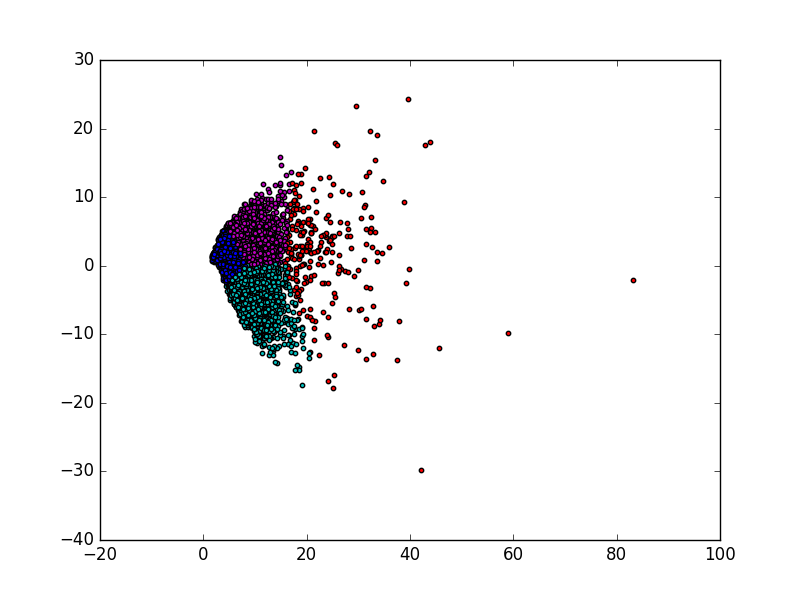

In [6]:
Image(filename='/home/anya/topic modeling/clusters.png')

Обучим теперь модель.

In [29]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=4, chunksize=500, update_every=1, passes=5, 
                       alpha='auto')
# alpha должна быть небольшой, так как чем она меньше, тем вероятнее, что документ будет иметь конкретный топик, а не множество
# auto дает в этом случае примерно такой же результат

INFO:gensim.models.ldamodel:using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online LDA training, 4 topics, 5 passes over the supplied corpus of 19381 documents, updating model once every 500 documents, evaluating perplexity every 5000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #500/19381
INFO:gensim.models.ldamodel:optimized alpha [0.44516582702268825, 0.44339474482174157, 0.4634049530872143, 0.45434438463170179]
INFO:gensim.models.ldamodel:merging changes from 500 documents into a model of 19381 documents
INFO:gensim.models.ldamodel:topic #0 (0.445): 0.004*россия + 0.004*миллион + 0.003*рубль + 0.003*тысяча + 0.003*миллиард + 0.003*рынок + 0.003*говорить + 0.003*доллар + 0.003*проект + 0.003*господин
INFO:gensim.models.ldamodel:topic #1 (0.443): 0.005*рубль + 0.005*россия + 0.004*миллиард + 

In [36]:
top_words = [[word for _, word in lda.show_topic(topicNumber, topn=15)] 
             for topicNumber in range(lda.num_topics)]
for i in range(len(top_words)):
    print(i+1, ' '.join(top_words[i]), '\n')

1 россия президент партия после человек путин мы матч команда я дело власть выбор владимир депутат 

2 мы человек я самый или автомобиль можно машина большой новый есть себя даже другой работа 

3 миллиард доллар рынок миллион рубль цена тысяча акция рост банка российский страна продажа проект россия 

4 господин рубль мы россия должный решение суд говорить система работа слово считать закон проект если 



Как и следовало ожидать, модель плохая (в коллекции явно больше 4 тем!), топики совсем не показательны, в процессе обучения перплексия уменьшилась совсем немного: с 330 до 312,7.  

Изначально я обучала модель на нелемматизированных документах -- на 50 топиках и 4 passes перплексия была 710,6, некотрые топики были плохо интерпретируемые, например: 
['ее', 'лет', 'она', 'даже', 'который', 'когда', 'под', 'был', 'раз', 'где'],
['можно', 'больше', 'или', 'чем', 'время', 'где', 'их', 'даже', 'они', 'чаще'],
другие вполне показательными:
['продукции', 'алкоголя', 'водки', 'сигарет', 'производства', 'запрет', 'пива', 'дал', 'знак', 'производителей'].
При использовании лемматизированных документов перплексия сразу уменьшается до 282,5, топики становятся более интерпретируемыми.

Что касается параметров модели, то они требуют еще опытов. Как лингвисту, мне интересно было бы понять, насколько и как связаны эти параметры модели с лингвистическими характеристиками документов (жанром, лексикой и другими особенностями).